FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Mine.txt'

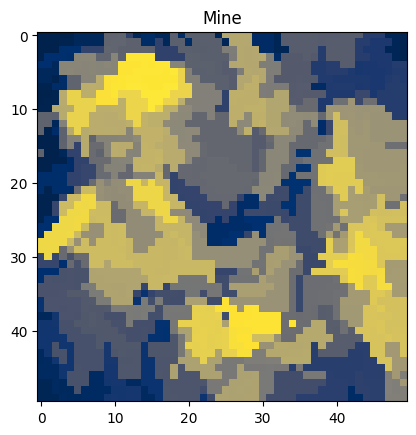

In [22]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon
from PIL import Image
from noise import snoise3

size = 50
n = 256
map_seed = 0

def voronoi(points, size):
    # add points at edges to eliminate infinite ridges
    edge_points = size*np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])
    new_points = np.vstack([points, edge_points])
    
    # calculate Voronoi tessellation
    vor = Voronoi(new_points)
    
    return vor

def voronoi_map(vor, size):
    # calculate Voronoi map
    vor_map = np.zeros((size, size), dtype=np.uint32)

    for i, region in enumerate(vor.regions):
        # skip empty regions and infinte ridge regions
        if len(region) == 0 or -1 in region: continue
        # get polygon vertices    
        x, y = np.array([vor.vertices[i][::-1] for i in region]).T
        # get pixels inside polygon
        rr, cc = polygon(x, y)
        # remove pixels out of image bounds
        in_box = np.where((0 <= rr) & (rr < size) & (0 <= cc) & (cc < size))
        rr, cc = rr[in_box], cc[in_box]
        # paint image
        vor_map[rr, cc] = i

    return vor_map

points = np.random.randint(0, size, (1000, 2))
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

def relax(points, size, k=10):  
    new_points = points.copy()
    for _ in range(k):
        vor = voronoi(new_points, size)
        new_points = []
        for i, region in enumerate(vor.regions):
            if len(region) == 0 or -1 in region: continue
            poly = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis=0)
            new_points.append(center)
        new_points = np.array(new_points).clip(0, size)
    return new_points

points = relax(points, size, k=100)
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

def noise_map(size, res, seed, octaves=1, persistence=0.5, lacunarity=2.0):
    map_seed = random.randint(0, 9999)
    scale = size/res
    return np.array([[
        snoise3(
            (x+0.1)/scale,
            y/scale,
            seed+map_seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        )
        for x in range(size)]
        for y in range(size)
    ])

boundary_displacement = 8
boundary_noise = np.dstack([noise_map(size, 2, 200, octaves=16), noise_map(size, 2, 250, octaves=16)])
boundary_noise = np.indices((size, size)).T + boundary_displacement*boundary_noise
boundary_noise = boundary_noise.clip(0, size-1).astype(np.uint32)

blurred_vor_map = np.zeros_like(vor_map)

for x in range(size):
    for y in range(size):
        j, i = boundary_noise[x, y]
        blurred_vor_map[x, y] = vor_map[i, j]

fig, ax = plt.subplots()
ax.set_title("Mine")
ax.imshow(blurred_vor_map, cmap="cividis")

with open("datasets/Mine.txt", "ab") as f:
    np.savetxt(f, blurred_vor_map)